# Computational Linear Algebra: Spectral CLustering Homework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Load the points from both datasets.

In [2]:
circle = pd.read_csv('Circle.csv', header=None, names=['x', 'y'])
spiral = pd.read_csv('Spiral.csv', header=None, names=['x', 'y', 'label'])
circle.head(), spiral.head()

(        x        y
 0  2.7147  0.81472
 1  2.8054  0.94572
 2  2.0253  0.20682
 3  2.8096  1.03310
 4  2.5257  0.79188,
        x     y  label
 0  31.95  7.95      3
 1  31.15  7.30      3
 2  30.45  6.65      3
 3  29.70  6.00      3
 4  28.90  5.55      3)

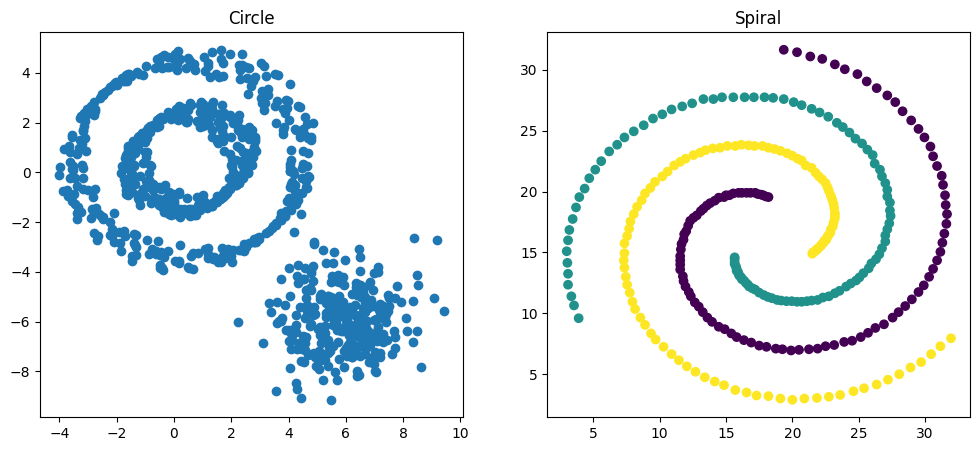

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].scatter(circle['x'],circle['y'])
ax[0].set_title('Circle')
ax[1].scatter(spiral['x'],spiral['y'],c=spiral['label'])
ax[1].set_title('Spiral')
plt.show()

In [4]:
circle_points = circle[['x', 'y']].values
spiral_points = spiral[['x', 'y']].values

Define the similarity function:

$$
s_{i,j} = \exp\left(-\frac{\|X_i - X_j\|^2}{2\sigma^2}\right)
$$



In [5]:
def create_similarity_matrix(X, sigma): 
    n_points = X.shape[0]
    similarity_matrix = np.zeros((n_points, n_points))

    for i in range(n_points):
        for j in range(n_points):
            similarity_matrix[i, j] = np.exp(-(np.linalg.norm(X[i] - X[j]))**2 / (2 * sigma**2))

    return similarity_matrix


Given a set of data points X and the similarity function, construct the k-nearest neighborhood similarity graph and its adjacency
matrix W. 

In [6]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors

def create_adjacency_matrix(X, k, sigma=1):        
    similarity_matrix = create_similarity_matrix(X, sigma)
    np.fill_diagonal(similarity_matrix, 0)  # diagonal elements are zero by definition
    # keep only the k highest values for each row/columns in the similarity matrix
    n_points = similarity_matrix.shape[0]
    W = np.zeros_like(similarity_matrix)

    for i in range(n_points):
        row = similarity_matrix[i]
        top_k_indices = np.argsort(row)[-k:]
        W[i, top_k_indices] = row[top_k_indices]

    W = np.maximum(W,W.T) # so that W is symmetric
    return W
 

### Changing the value of K
#### K = 10

In [7]:
W = create_adjacency_matrix(circle_points, 10)

Construct the degree matrix D and the Laplacian matrix L = D −W. We apply also the same process to the normalized symmetric Laplacian matrix $L_{\text{sym}} \in \mathbb{R}^{N \times N}$ that is defined as

$$
L_{\text{sym}} := D^{-\frac{1}{2}} L D^{-\frac{1}{2}} = I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}
$$ 

In [8]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [9]:
W = csr_matrix(W)
D = csr_matrix(D)

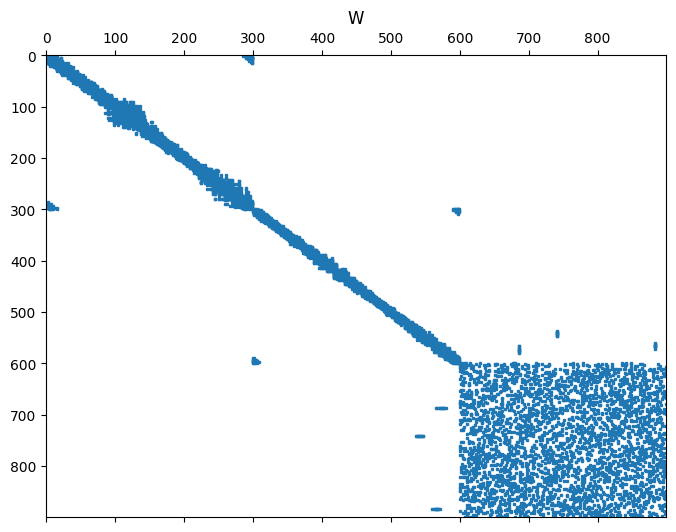

In [10]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

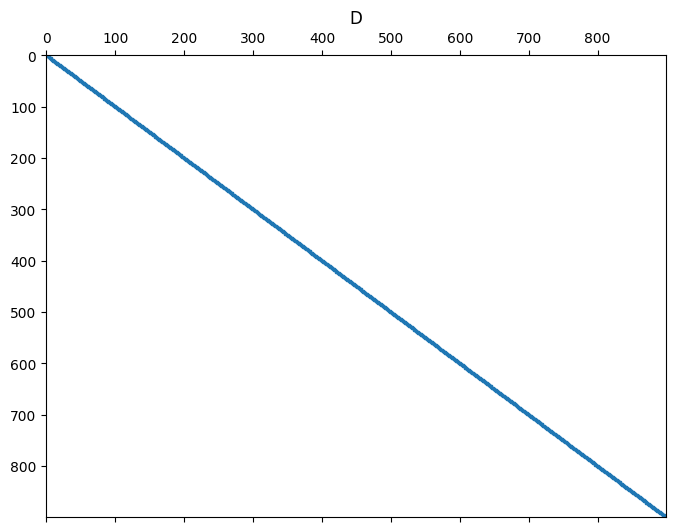

In [11]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [12]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))

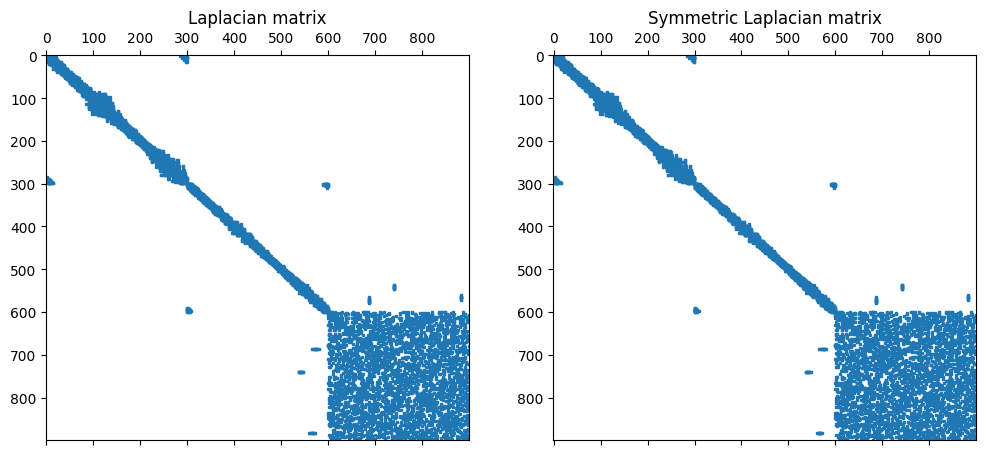

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

Compute the number of connected components of the similarity graph. The number of connected components correspond to the nummber of 0 eigenvalues of the Laplacian matrix L. We can use the *Inverse Power Method* and the *Deflation Method* to compute eigenvalues and eigenvectors.

In [14]:
def inverse_power_method(A, v0, maxIter=1000, relTol=1e-8, p=0):
    v0 = v0 / np.linalg.norm(v0,2)
    l0 = p
    k = 0
    while True:
        v1 = np.linalg.solve(A - p * np.eye(A.shape[0]), v0)
        mu = np.dot(v1, v0)
        v1 = v1 / np.linalg.norm(v1,2)
        k += 1
        if(k>maxIter or np.abs(mu-l0)<relTol*(np.abs(mu))):
            break

        v0 = v1
        l0 = mu
    return mu, v1


In [15]:
def deflation_method(A, k):
    eigenvalues = []

    A_current = A.copy()

    for i in range(k):
        lambda_i, v_i = inverse_power_method(A_current, np.random.rand(A.shape[0]), maxIter=1000, relTol=1e-8)
        lambda_i = 1/lambda_i
        eigenvalues.append(lambda_i)
        A_current = A_current - np.outer(v_i, v_i)

    return np.array(eigenvalues)

In [16]:
eigenvalues = deflation_method(L, 15)
eigenvalues_sym = deflation_method(L_sym, 15)

In [17]:
num_connected_components = np.sum(np.isclose(eigenvalues, 0, atol=1e-8))
print("Number of connected components:", num_connected_components)

Number of connected components: 2


Compute some small eigenvalues of L and use their values to choose a
suitable number of clusters M for the points data-sets.

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

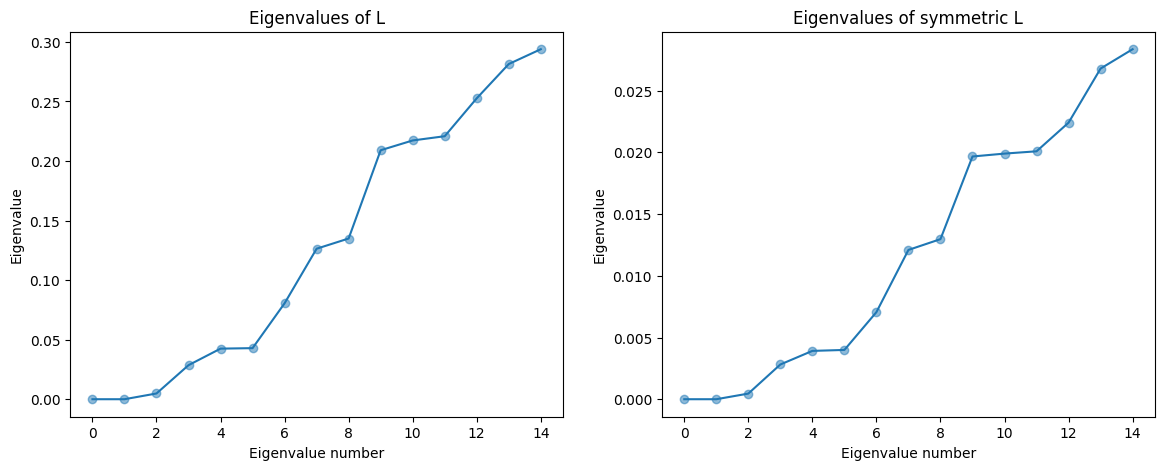

In [18]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt


Compute the $M$ eigenvectors $u_1, u_2, \dots, u_M \in \mathbb{R}^N$ that correspond to the $M$ smallest eigenvalues of the Laplacian matrix. Define the matrix $U \in \mathbb{R}^{N \times M}$ with these eigenvectors as columns. We try with M=2 and M=3.
For $i = 1, \dots, N$, let $\mathbf{y}_i \in \mathbb{R}^M$ be the vector corresponding to the $i$-th row of $U$. Cluster the points $\mathbf{y}_i$, $i = 1, \dots, N$ in $\mathbb{R}^M$ with the $k$-means algorithm into clusters $C_1, \dots, C_M$.

In [19]:
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

In [20]:
def show_clustering(df, column_name1, column_name2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(df['x'], df['y'], c=df[column_name1])
    ax[0].set_title('Spectral clustering with L')
    ax[1].scatter(df['x'], df['y'], c=df[column_name2])
    ax[1].set_title('Spectral clustering with symmetric L')
    plt.show()

Laplacian - The silhouette score of the clustering with M = 2 is 0.19184998033205108
Symmetric Laplacian - The silhouette score of the clustering with M = 2 is 0.19184998033205108


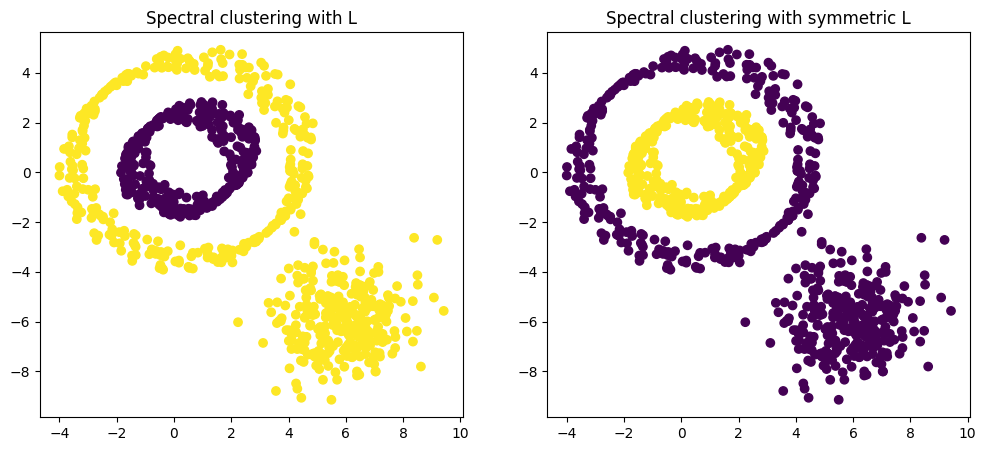

Laplacian - The silhouette score of the clustering with M = 3 is 0.32326843682162765
Symmetric Laplacian - The silhouette score of the clustering with M = 3 is 0.32326843682162765


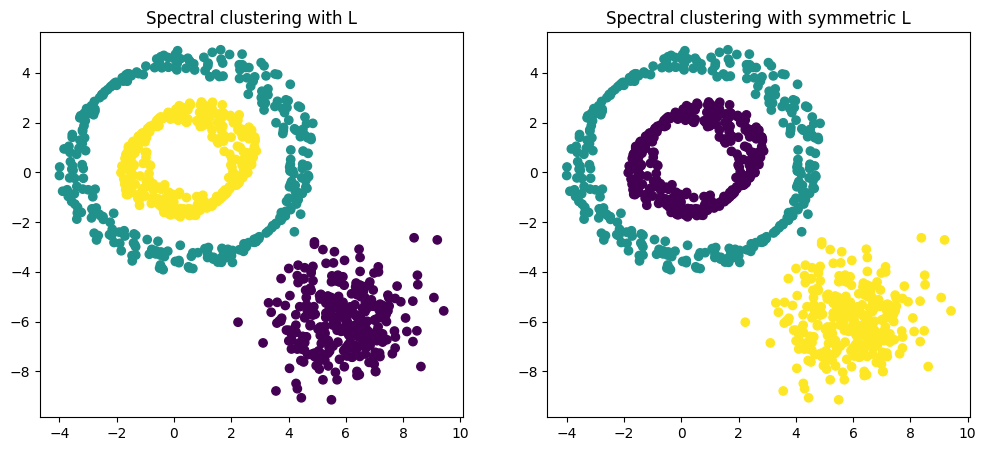

In [21]:
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    print(f"Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster'])}")
    km.fit(U_sym)
    circle['cluster_sym'] = km.labels_ 
    print(f"Symmetric Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster_sym'])}")
    show_clustering(circle, "cluster", "cluster_sym")

#### K = 20

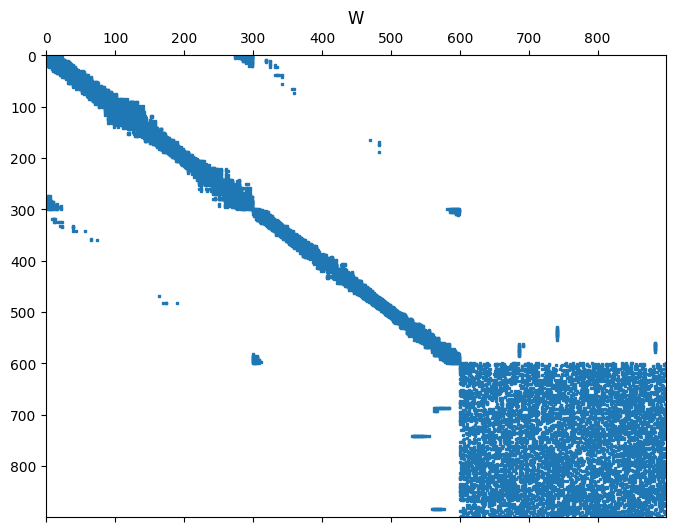

In [22]:
# Define W adjacency matrix
W = create_adjacency_matrix(circle_points, 20)
# Compute D degree matrix
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])
W = csr_matrix(W)
D = csr_matrix(D)

# Plot W
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

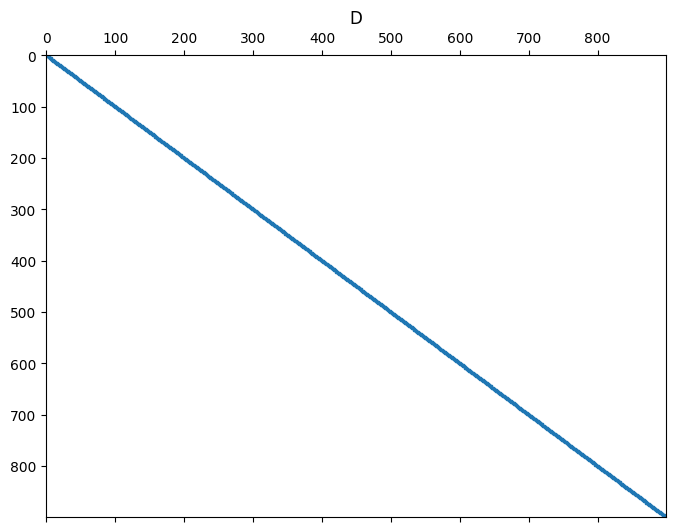

In [23]:
# Plot D
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

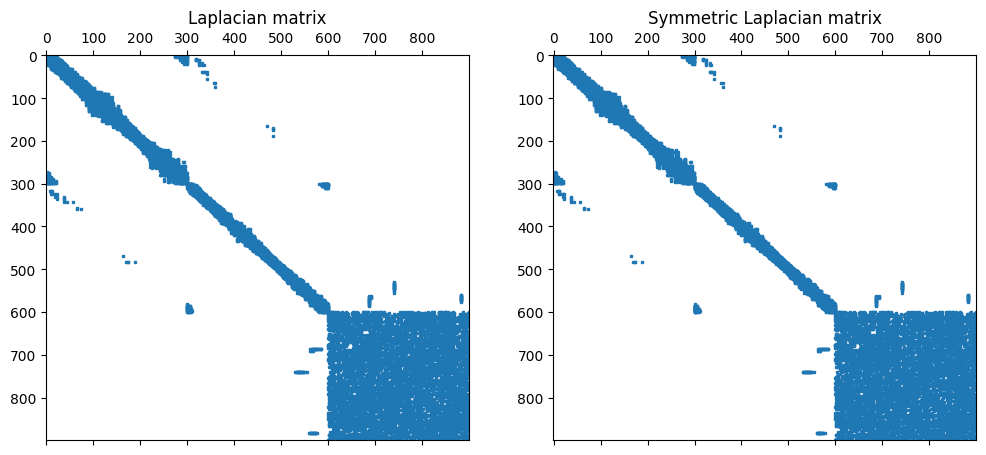

In [24]:
# Compute Laplacian matrix and symmetric Laplacian matrix
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

Number of connected components: 1


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

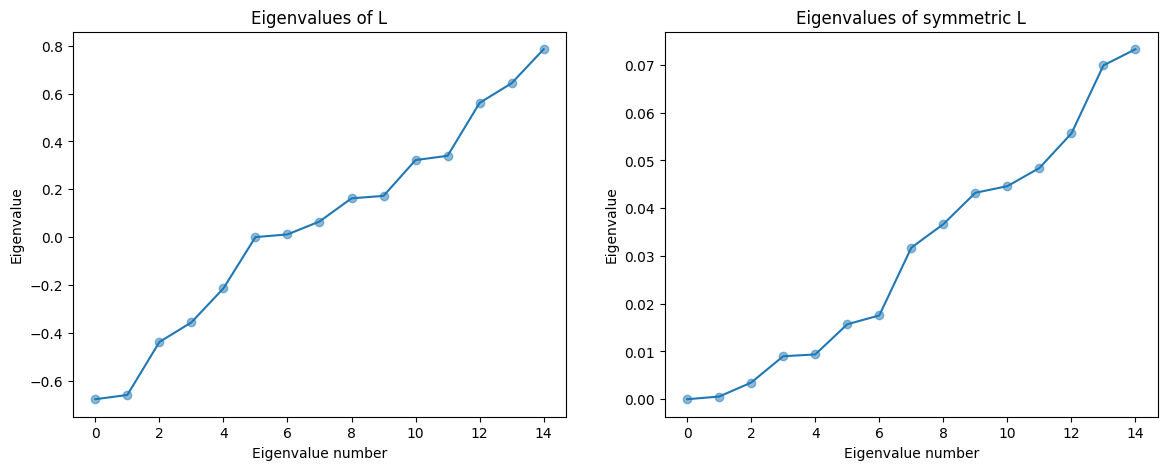

In [25]:
# Compute eigenvalues using deflation method
eigenvalues = deflation_method(L, 15)
eigenvalues_sym = deflation_method(L_sym, 15)

# Compute number of connected components
num_connected_components = np.sum(np.isclose(eigenvalues, 0, atol=1e-8))
print("Number of connected components:", num_connected_components)

# Plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt

Laplacian - The silhouette score of the clustering with M = 2 is 0.5844631806466254
Symmetric Laplacian - The silhouette score of the clustering with M = 2 is 0.5844631806466254


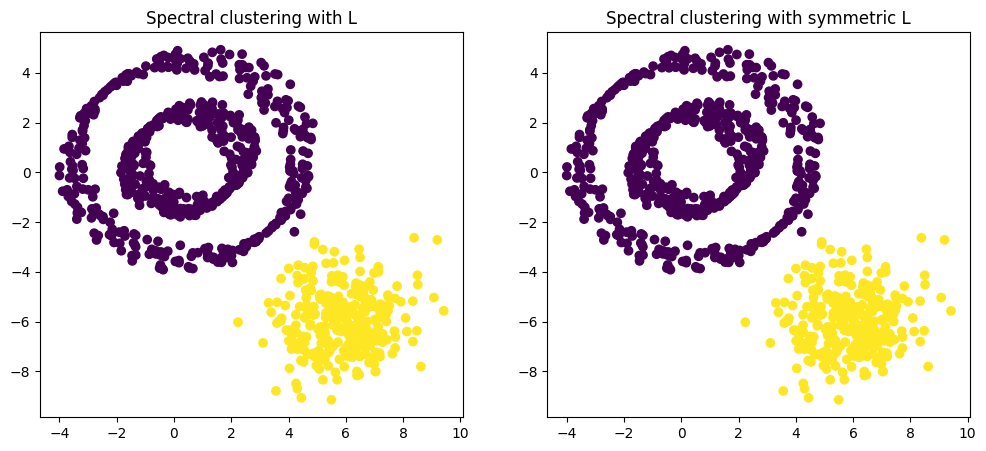

Laplacian - The silhouette score of the clustering with M = 3 is 0.32326843682162765
Symmetric Laplacian - The silhouette score of the clustering with M = 3 is 0.32326843682162765


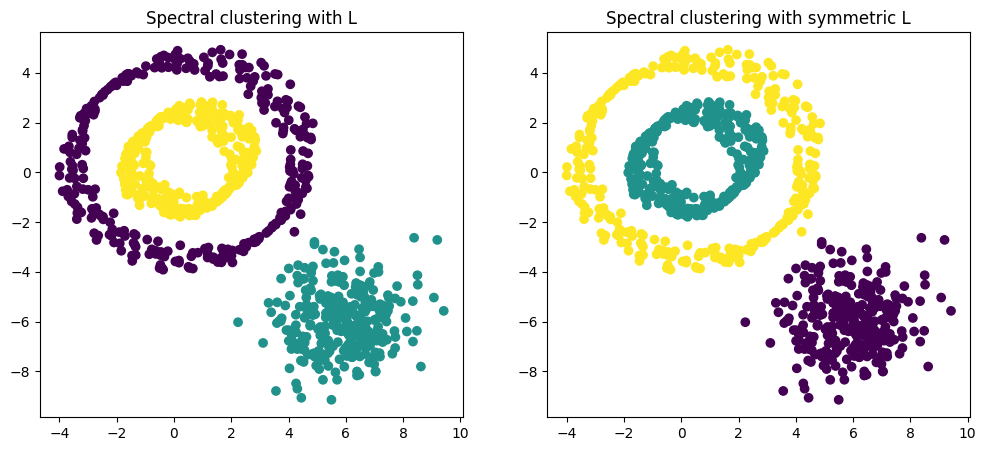

In [26]:
# Compute eigenvectors of L and L_sym
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

# Show clustering
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    print(f"Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster'])}")
    km.fit(U_sym)
    circle['cluster_sym'] = km.labels_ 
    print(f"Symmetric Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster_sym'])}")
    show_clustering(circle, "cluster", "cluster_sym")

#### K = 40

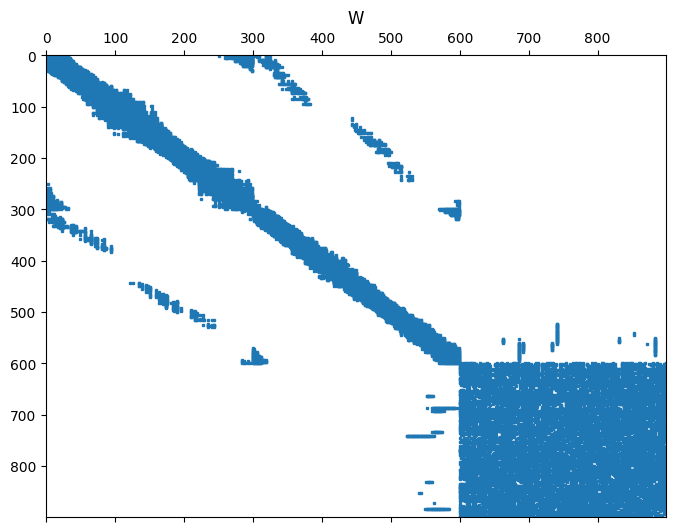

In [27]:
# Define W adjacency matrix
W = create_adjacency_matrix(circle_points, 40)
# Compute D degree matrix
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])
W = csr_matrix(W)
D = csr_matrix(D)

# Plot W
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

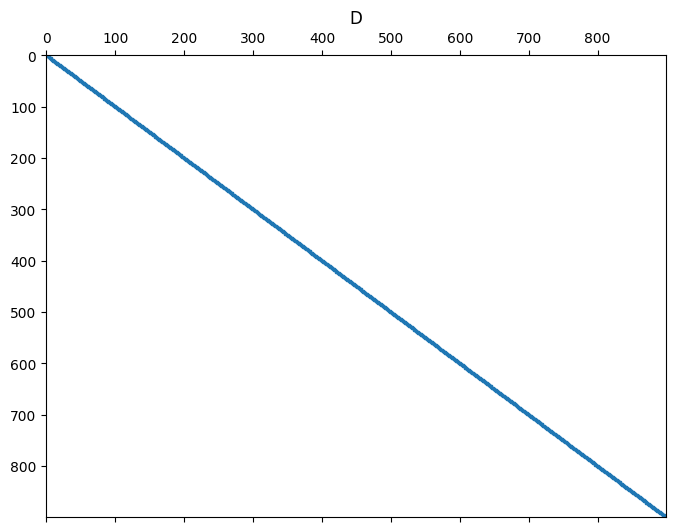

In [28]:
# Plot D
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

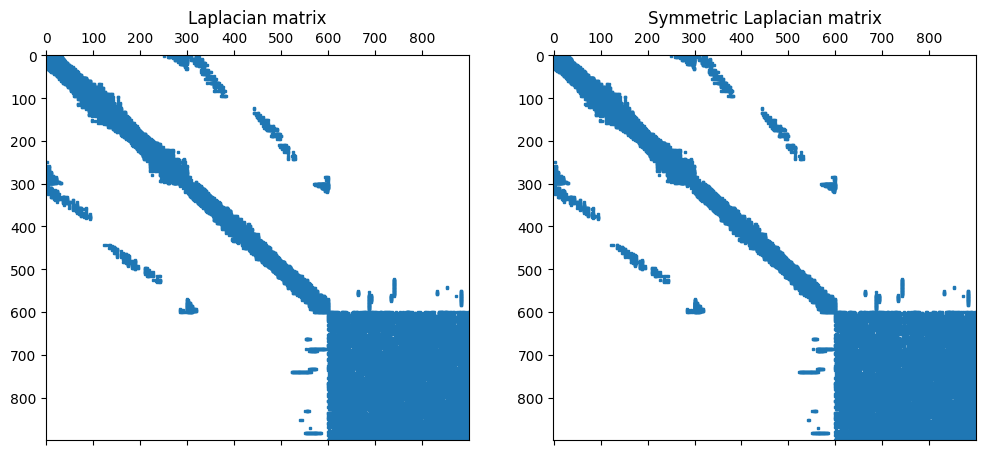

In [29]:
# Compute Laplacian matrix and symmetric Laplacian matrix
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

Number of connected components: 1


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

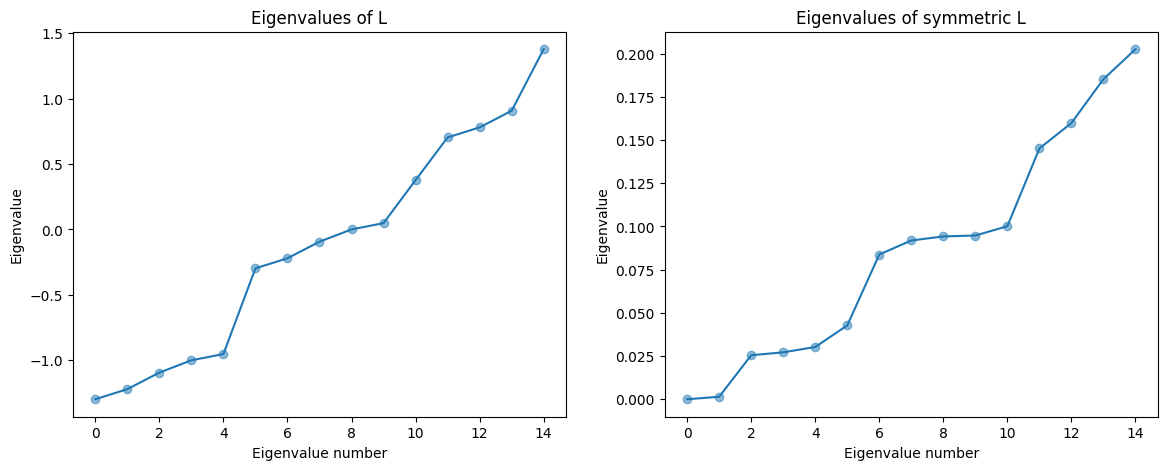

In [30]:
# Compute eigenvalues using deflation method
eigenvalues = deflation_method(L, 15)
eigenvalues_sym = deflation_method(L_sym, 15)

# Compute number of connected components
num_connected_components = np.sum(np.isclose(eigenvalues, 0, atol=1e-8))
print("Number of connected components:", num_connected_components)

# Plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt

Laplacian - The silhouette score of the clustering with M = 2 is 0.5844631806466254
Symmetric Laplacian - The silhouette score of the clustering with M = 2 is 0.5828272521608201


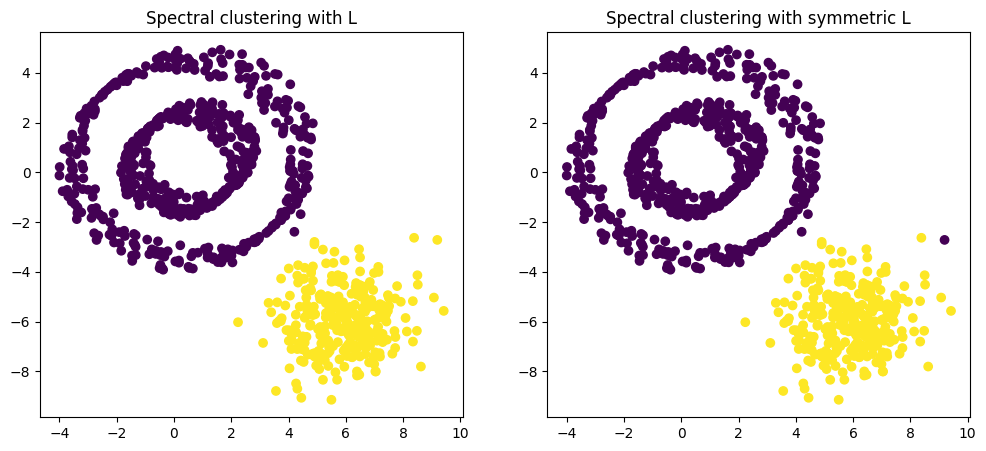

Laplacian - The silhouette score of the clustering with M = 3 is 0.40272559643258354
Symmetric Laplacian - The silhouette score of the clustering with M = 3 is 0.40299335665362174


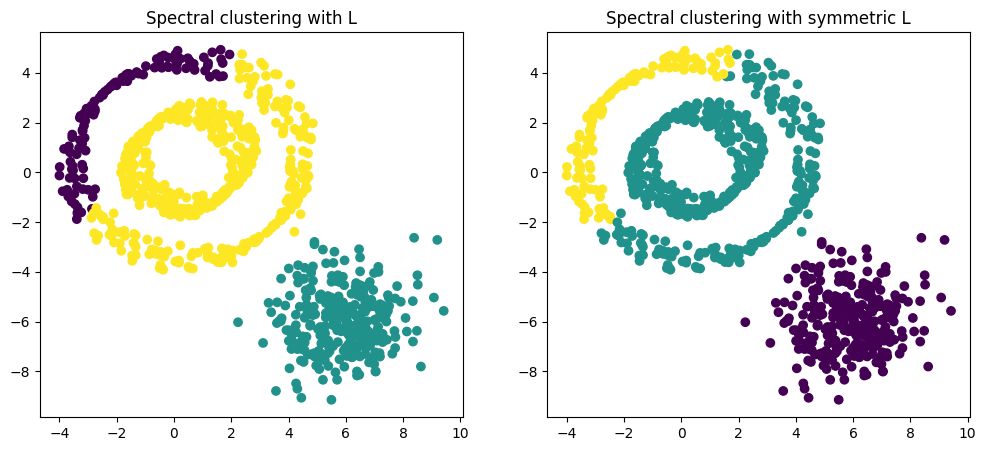

In [31]:
# Compute eigenvectors of L and L_sym
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

# Show clustering
M = [2,3]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    circle['cluster'] = km.labels_ 
    print(f"Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster'])}")
    km.fit(U_sym)
    circle['cluster_sym'] = km.labels_ 
    print(f"Symmetric Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster_sym'])}")
    show_clustering(circle, "cluster", "cluster_sym")

## SPIRAL DATASET

Do same steps for spiral dataset.

In [32]:
W = create_adjacency_matrix(spiral_points, 10)

In [33]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])    

In [34]:
W = csr_matrix(W)
D = csr_matrix(D)

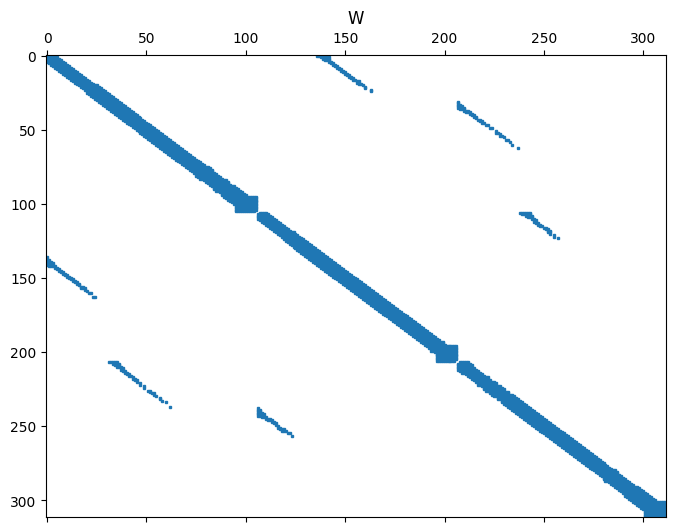

In [35]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

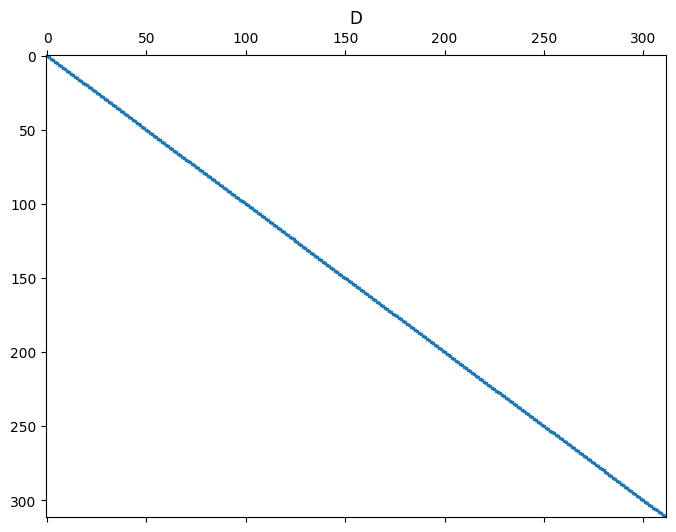

In [36]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [37]:
L = D - W
L_sym = D.power(-0.5).dot(L).dot(D.power(-0.5))

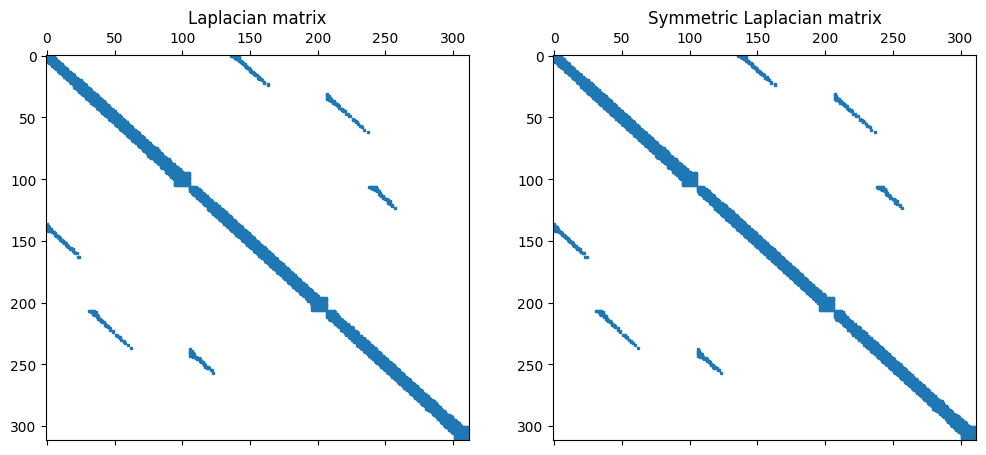

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].spy(L, markersize=2, aspect='auto')
ax[0].set_title('Laplacian matrix')
ax[1].spy(L_sym, markersize=2, aspect='auto')
ax[1].set_title('Symmetric Laplacian matrix')
plt.show()

In [39]:
eigenvalues = deflation_method(L, 15)
eigenvalues_sym = deflation_method(L_sym, 15)

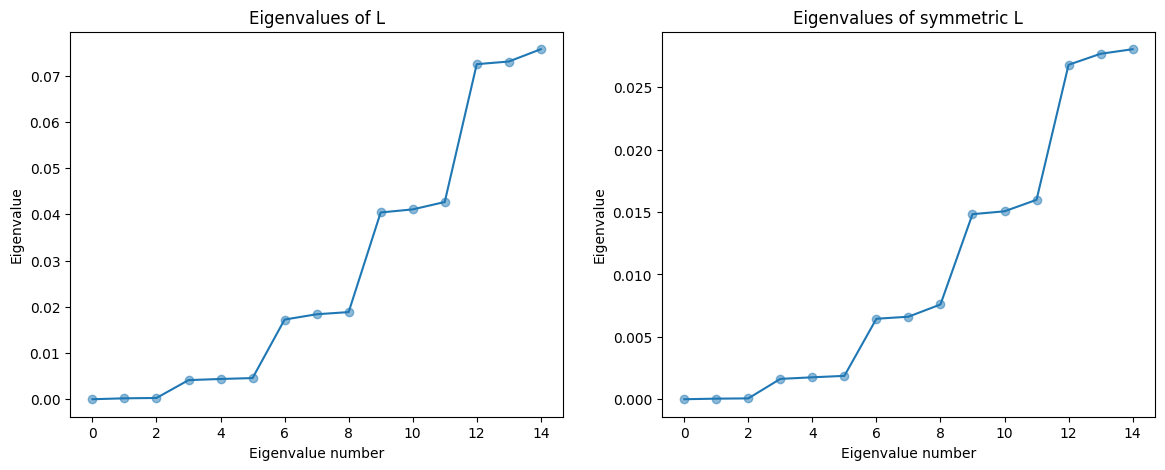

In [40]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues))
ax[0].scatter(np.arange(0,15,step=1), np.sort(eigenvalues), alpha=0.5)
ax[0].set_title('Eigenvalues of L')
ax[0].set_xlabel("Eigenvalue number")
ax[0].set_ylabel("Eigenvalue")
ax[1].plot(np.arange(0,15,step=1.0), np.sort(eigenvalues_sym))
ax[1].scatter(np.arange(0,15,step=1), np.sort(eigenvalues_sym), alpha=0.5)
ax[1].set_title('Eigenvalues of symmetric L')
ax[1].set_xlabel("Eigenvalue number")
ax[1].set_ylabel("Eigenvalue")
plt.show()

In [41]:
_ , eigenvectors = eigsh(L, k=15, which='SM')
_ , eigenvectors_sym = eigsh(L_sym, k=15, which='SM')

Laplacian - The silhouette score of the clustering with M = 3 is 0.40272559643258354
Symmetric Laplacian - The silhouette score of the clustering with M = 3 is 0.40299335665362174


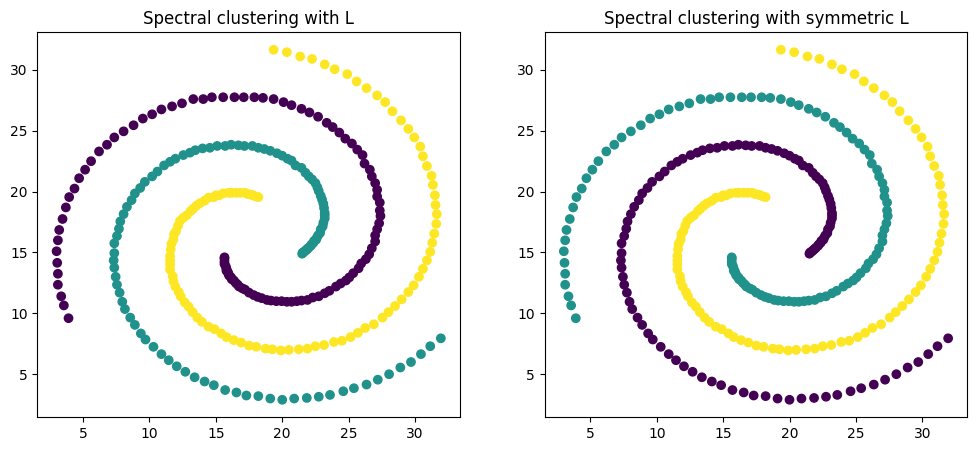

Laplacian - The silhouette score of the clustering with M = 4 is 0.40272559643258354
Symmetric Laplacian - The silhouette score of the clustering with M = 4 is 0.40299335665362174


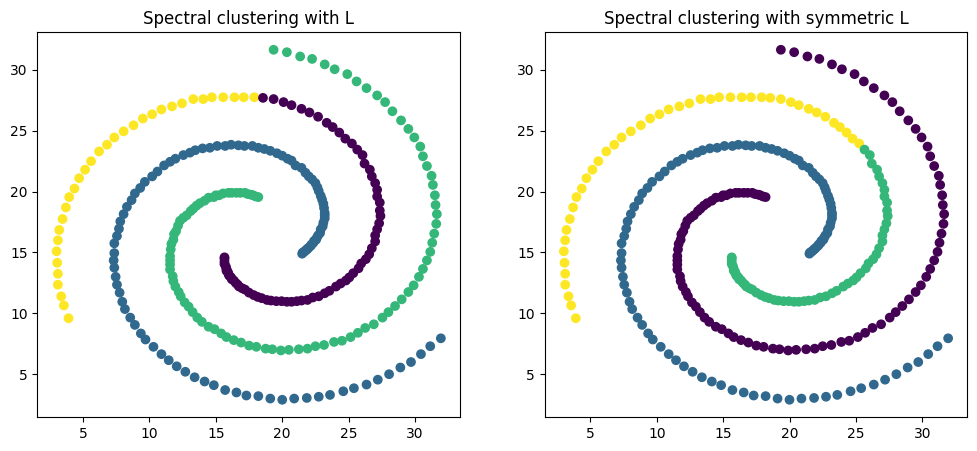

In [42]:
M = [3,4]
for m in M:
    U = eigenvectors[:, 0:m]
    U_sym = eigenvectors_sym[:, 0:m]
    km = KMeans(n_clusters=m)
    km.fit(U)
    spiral['cluster'] = km.labels_ 
    print(f"Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster'])}")
    km.fit(U_sym)
    spiral['cluster_sym'] = km.labels_ 
    print(f"Symmetric Laplacian - The silhouette score of the clustering with M = {m} is {silhouette_score(circle_points, circle['cluster_sym'])}")
    show_clustering(spiral, "cluster", "cluster_sym")

## Using other Clustering Methods

Compute the clusters for the same set of points with other clustering
methods (k-means,...) and compare the results.

### K-Means

In [43]:
km = KMeans(n_clusters=3)
km.fit(circle_points)

KMeans(n_clusters=3)

Text(0.5, 1.0, 'K-means clustering')

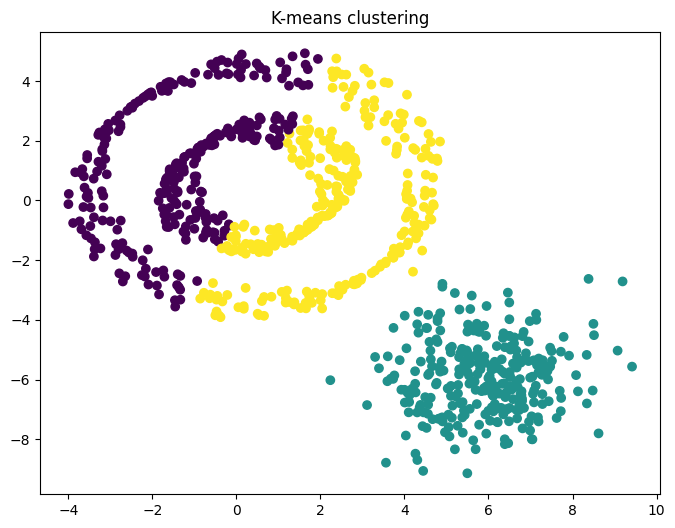

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=km.labels_)
plt.title("K-means clustering")

In [45]:
km = KMeans(n_clusters=3)
km.fit(spiral_points)

KMeans(n_clusters=3)

Text(0.5, 1.0, 'K-means clustering')

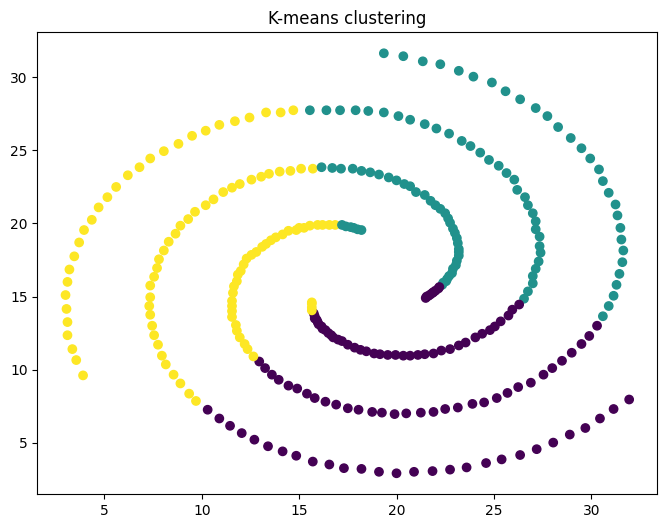

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=km.labels_)
plt.title("K-means clustering")

### DBSCAN

In [47]:
cls = DBSCAN()
cls.fit(circle_points)

DBSCAN()

Text(0.5, 1.0, 'DBSCAN clustering')

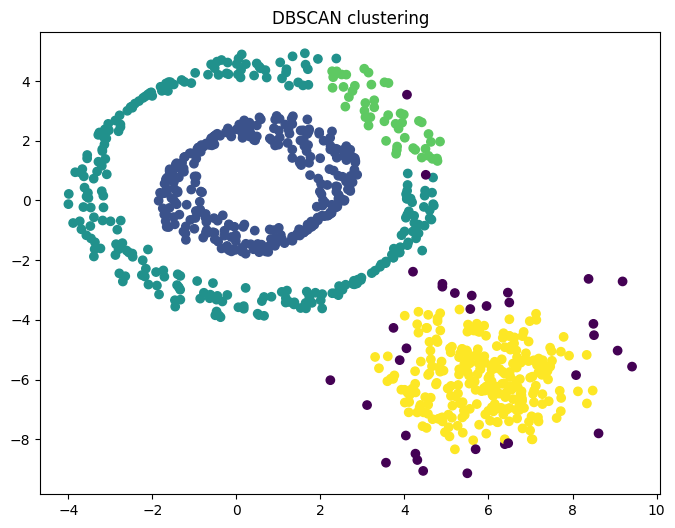

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(circle['x'], circle['y'], c=cls.labels_)
plt.title("DBSCAN clustering")

In [49]:
cls.fit(spiral_points)

DBSCAN()

Text(0.5, 1.0, 'DBSCAN clustering')

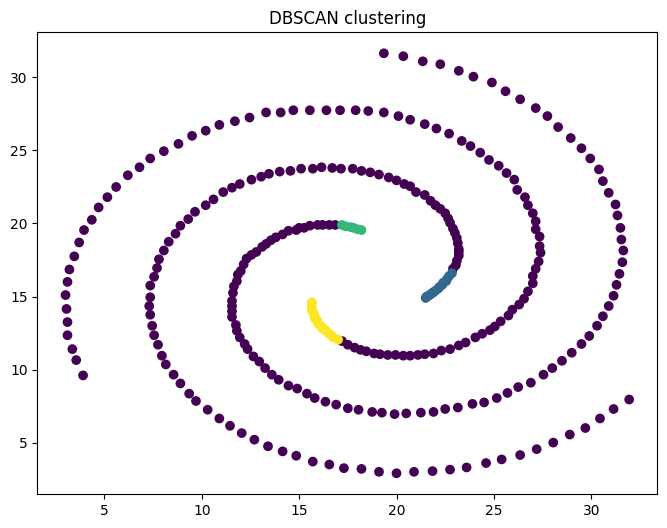

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(spiral['x'], spiral['y'], c=cls.labels_)
plt.title("DBSCAN clustering")

## SYNTHETIC 3D DATASET

We try to apply the above procedure to a synthetic dataset of 3D points.

In [51]:
from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples = 500, n_features = 3, centers = 4, random_state=42)

In [52]:
X

array([[  2.18598499, -10.52764551,   9.25410949],
       [ -8.79189121,   5.96366677,   2.7685538 ],
       [  3.25084651,  -6.54731318,  -7.62859613],
       ...,
       [  1.55788177,  -6.24684533,  -4.60941674],
       [-10.12131998,   8.31978973,   1.52854365],
       [  4.49233179,  -8.75478115,   7.4044614 ]])

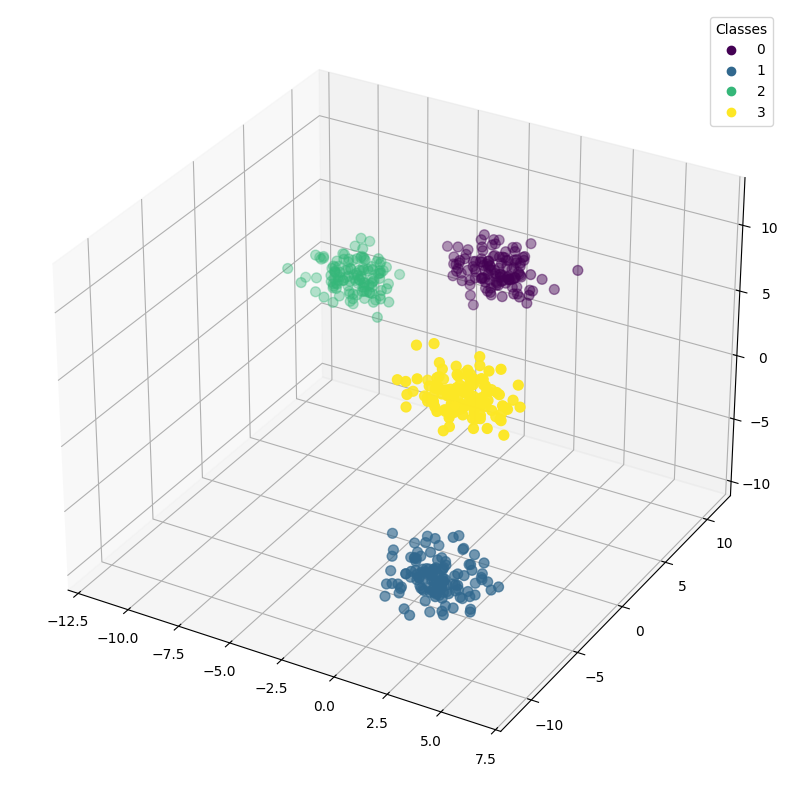

In [53]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=50)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

In [54]:
W = create_adjacency_matrix(X, 10)

In [55]:
D = np.zeros_like(W)
for i in range(W.shape[0]):
    D[i, i] = np.sum(W[i, :])  

In [56]:
W = csr_matrix(W)
D = csr_matrix(D)

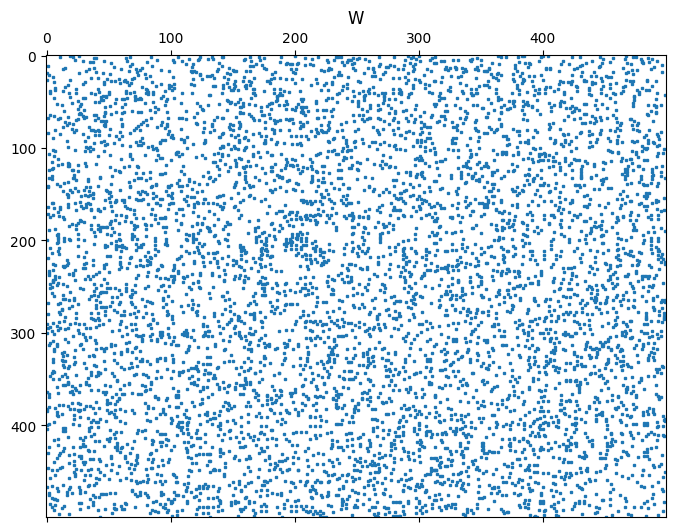

In [57]:
plt.figure(figsize=(8, 6))
plt.spy(W, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("W")
plt.show()

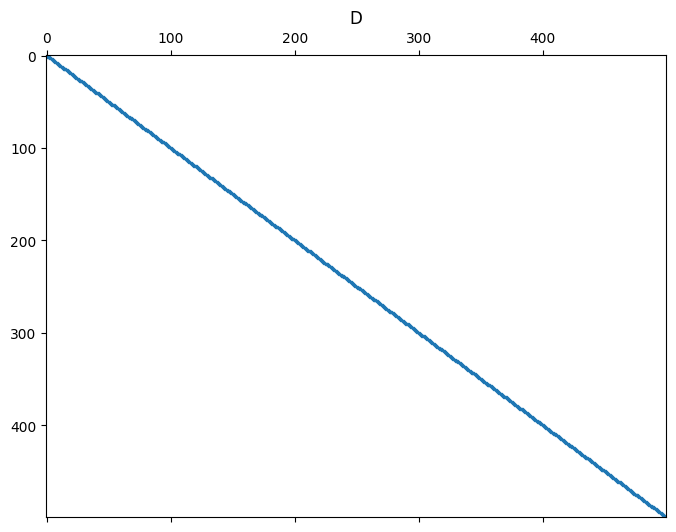

In [58]:
plt.figure(figsize=(8, 6))
plt.spy(D, markersize=2, aspect='auto')  # Visualize the sparsity pattern
plt.title("D")
plt.show()

In [59]:
L = D - W

Text(0.5, 1.0, 'Laplacian matrix')

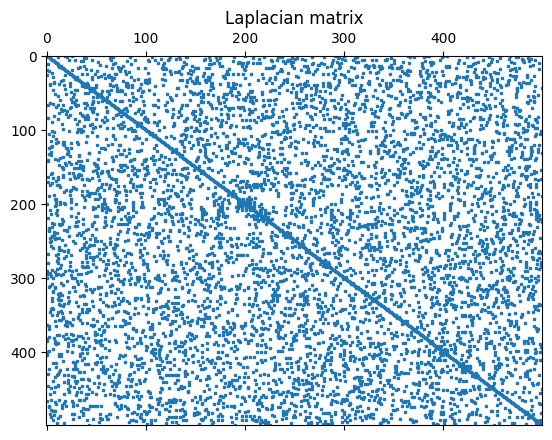

In [60]:
plt.plot( figsize=(12, 5))
plt.spy(L, markersize=2, aspect='auto')
plt.title('Laplacian matrix')

In [61]:
eigenvalues = deflation_method(L, 15)

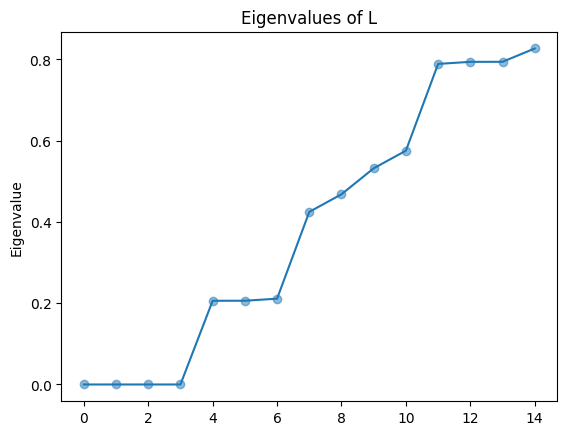

In [62]:
#plot on x axis the # of the eigenvalue and on y axis the value of the eigenvalue
plt.plot(figsize=(14, 5))
plt.plot(np.arange(0,15,step=1.0), np.sort(np.abs(eigenvalues)))
plt.scatter(np.arange(0,15,step=1), np.sort(np.abs(eigenvalues)), alpha=0.5)
plt.title('Eigenvalues of L')
plt.ylabel("Eigenvalue")
plt.show()

In [63]:
_, eigenvectors = eigsh(L, k=15, which='SM')

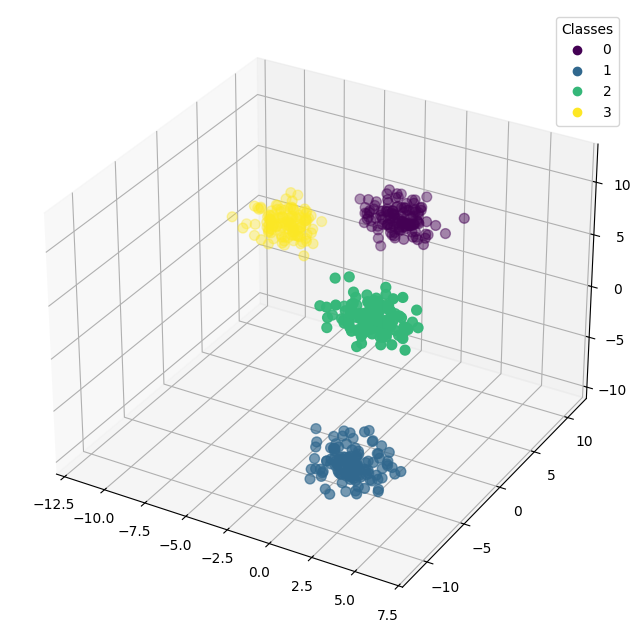

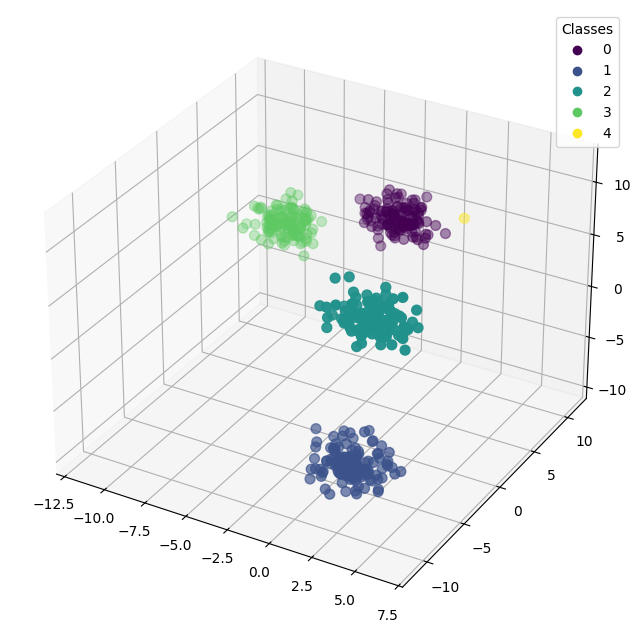

In [64]:
M = [4,5]
for m in M:
    U = eigenvectors[:, 0:m] 
    km = KMeans(n_clusters=m)
    km.fit(U)
    y_pred = km.labels_ 
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred, s=50)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()